# 04 Data Processing and Factor Computation

This notebook loads the processed dependency size data, calculates linguistic factors (such as HCS and Diagonal factors), and generates analysis tables.

**Output**:
- `data/hcs_factors.csv`: Computed HCS factors for all languages.
- `data/verb_centered_table.txt`: Verb-centered constituent size table.

In [1]:
# !pip install openpyxl

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
from importlib import reload

# Custom modules
import data_utils
import compute_factors
import verb_centered_analysis

# Reload to ensure latest changes are picked up
reload(compute_factors)
reload(verb_centered_analysis)

<module 'verb_centered_analysis' from '/bigstorage/kim/typometrics/dataanalysis/verb_centered_analysis.py'>

In [3]:
# Configuration
DATA_DIR = "data"
OUTPUT_DIR = "data"

## 1. Load Data

In [4]:
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))
langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']

print(f"Loaded metadata for {len(langNames)} languages")

Loaded metadata from data/metadata.pkl
Loaded metadata for 186 languages


In [5]:
# Load average sizes
with open(os.path.join(DATA_DIR, 'all_langs_average_sizes.pkl'), 'rb') as f:
    all_langs_average_sizes_filtered = pickle.load(f)

# Save filtered data for notebook 05 (if needed by downstream)
with open(os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl'), 'wb') as f:
    pickle.dump(all_langs_average_sizes_filtered, f)

print(f"Loaded average sizes for {len(all_langs_average_sizes_filtered)} languages")

Loaded average sizes for 185 languages


## 2. Compute HCS Factors

In [6]:
hcs_df = compute_factors.compute_hcs_factors(
    all_langs_average_sizes_filtered, 
    langNames, 
    langnameGroup
)

print(f"Computed HCS factors for {len(hcs_df)} languages")
print(hcs_df.head())

Computed HCS factors for 170 languages
    language_code  language_name           group  right_1_totright_2  \
80             ko         Korean           Other            1.881159   
116           pad        Paumarí  South-American            2.333333   
146            tn         Tswana     Niger-Congo            2.500000   
137           ssp    SpanishSign   Indo-European            1.750000   
144           qte  TeluguEnglish       Dravidian            1.000000   

     right_2_totright_2  hcs_factor  
80             1.055072    0.560863  
116            1.666667    0.714286  
146            2.250000    0.900000  
137            1.625000    0.928571  
144            1.000000    1.000000  


In [7]:
hcs_path = os.path.join(OUTPUT_DIR, 'hcs_factors.csv')
hcs_df.to_csv(hcs_path, index=False)
print(f"Saved HCS factors to {hcs_path}")

Saved HCS factors to data/hcs_factors.csv


## 3. Verb-Centered Constituent Size Analysis

Verb-Centered Constituent Size Analysis = a table with consituent size averages X per construction of dependents to the right and the left of the verb: 
      VXXXX
      VXXX
      VXX
      VX
     XV
    XXV
   XXXV
  XXXXV

This table shold come in multiple options:

1. Simple: just showing the average constituent size X per construction of dependents to the right and the left of the verb
2. Horizontal Growth: inbetween two Xs, the factor of growth going from left to right
3. Horizontal Growth: inbetween two Xs, the factor of growth going from right to left
4. Diagonal Growth added as an extra line: Going up right, the growth factor going between the last X of one to the next constructio, such as between the last X of VXXX to the last X of VXXXX etc.
5. The same as 4 but going down left.



In [8]:
# Verb-Centered Constituent Size Analysis
position_averages = verb_centered_analysis.compute_average_sizes_table(all_langs_average_sizes_filtered)
table_str = verb_centered_analysis.format_verb_centered_table(position_averages)

print(table_str)

VERB-CENTERED CONSTITUENT SIZE TABLE

                                        V                                   
R tot=4:                                  V   1.878   2.475   3.350   6.684
R tot=3:                                  V   1.757   2.744   5.689
R tot=2:                                  V   2.000   4.753
R tot=1:                                  V   4.326
------------------------------------------------------------------------------------------------------------------------
L tot=1:                            2.251 V
L tot=2:                    1.853   2.429 V
L tot=3:            1.749   2.128   2.646 V
L tot=4:    1.642   2.072   2.528   2.964 V
Mode: Factors=False, Diagonals=False, Direction=diverging
Table saved to: data/verb_centered_table.tsv


In [9]:
table_path = os.path.join(OUTPUT_DIR, 'verb_centered_table.txt')
with open(table_path, 'w') as f:
    f.write(table_str)
print(f"Saved table to {table_path}")

Saved table to data/verb_centered_table.txt


## 4. Compute Disorder Percentages

For each configuration (e.g., R tot=4), compute the percentage of languages where the constituent sizes are NOT strictly ordered (monotonically increasing/decreasing).

In [10]:
import compute_disorder
from importlib import reload
reload(compute_disorder)

# Compute disorder statistics
disorder_df, disorder_percentages = compute_disorder.compute_disorder_statistics(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup
)

print(f"Computed disorder for {len(disorder_df)} languages")
print("\nDisorder percentages by configuration:")
for (side, tot), pct in sorted(disorder_percentages.items()):
    if pct is not None:
        print(f"  {side} tot={tot}: {pct:.1f}% disordered")

print("\n", disorder_df.head())

Computed disorder for 185 languages

Disorder percentages by configuration:
  left tot=2: 87.0% disordered
  left tot=3: 94.9% disordered
  left tot=4: 99.4% disordered
  right tot=2: 6.5% disordered
  right tot=3: 20.7% disordered
  right tot=4: 36.4% disordered

   language_code language_name           group right_tot_2_disordered  \
0           abq         Abaza       Caucasian                  False   
1            ab        Abkhaz       Caucasian                  False   
2            af     Afrikaans   Indo-European                  False   
3           aqz       Akuntsu  South-American                   True   
4            sq      Albanian   Indo-European                  False   

   left_tot_2_disordered left_tot_3_disordered left_tot_4_disordered  \
0                   True                  True                  True   
1                   True                  True                  True   
2                  False                 False                  True   
3            

In [11]:
# Save disorder data
disorder_path = os.path.join(OUTPUT_DIR, 'disorder_percentages.csv')
disorder_df.to_csv(disorder_path, index=False)
print(f"Saved disorder data to {disorder_path}")

Saved disorder data to data/disorder_percentages.csv


In [12]:
# Print verb-centered table WITH disorder percentages
reload(verb_centered_analysis)

table_with_disorder = verb_centered_analysis.format_verb_centered_table(
    position_averages,
    show_horizontal_factors=True,
    show_diagonal_factors=True,
    arrow_direction='rightwards',
    disorder_percentages=disorder_percentages
)

print(table_with_disorder)

VERB-CENTERED CONSTITUENT SIZE TABLE
WITH GROWTH FACTORS

                                                                            V                                                                       
R tot=4:                                                                      V   1.878   ×1.32→      2.475   ×1.35→      3.350   ×2.00→      6.684  [unordered 36.4%]
                                                                                         ×1.41 ↗             ×1.22 ↗             ×1.17 ↗           
R tot=3:                                                                      V   1.757   ×1.56→      2.744   ×2.07→      5.689  [unordered 20.7%]
                                                                                         ×1.37 ↗             ×1.20 ↗           
R tot=2:                                                                      V   2.000   ×2.38→      4.753  [unordered 6.5%]
                                                                             

## 2b. Compute Sentence-Level Disorder (Optional)

this cell is useful:
* It handles saving: The new unified processing block I added computes the data (sentence_disorder_pct), but it does not save it. This cell converts that raw data into a DataFrame and saves it to sentence_disorder_percentages.csv and .pkl.
* It formats the data: It transforms the raw nested dictionary into a flat table structure that is needed for the subsequent notebooks.

Set `compute_sentence_disorder=True` to enable this analysis.

In [13]:
import os
import pandas as pd
import pickle
from importlib import reload
import verb_centered_analysis

# Reload the module to use the latest table formatting logic
reload(verb_centered_analysis)

DATA_DIR = 'data'
OUTPUT_TABLE_DIR = os.path.join(DATA_DIR, 'tables')

print("--- Starting Mass Table Generation ---")

# 1. Load Average Sizes (Notebook 04 typically loads this, but ensuring it here)
# Variable `all_langs_average_sizes_filtered` should exist if you ran previous cells.
if 'all_langs_average_sizes_filtered' not in locals():
    # Try to load it if missing
    avg_path = os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl')
    if os.path.exists(avg_path):
        with open(avg_path, 'rb') as f:
            all_langs_average_sizes_filtered = pickle.load(f)
        print("Loaded average sizes from disk.")
    else:
        print("ERROR: 'all_langs_average_sizes_filtered' not found. Run Cells 1-4 first.")

# 2. Load Ordering Statistics (The new granular data)
ordering_stats = {}
disorder_path = os.path.join(DATA_DIR, 'sentence_disorder_percentages.pkl')

if os.path.exists(disorder_path):
    with open(disorder_path, 'rb') as f:
        loaded_data = pickle.load(f)
        
    # Check if the data is in the old format (percentages) or new format (triplet counts)
    # New format keys are (side, tot, idx). Old format is (side, tot).
    # We can perform a quick check on the first non-empty language
    sample_lang = next(iter(loaded_data))
    sample_keys = list(loaded_data[sample_lang].keys()) if loaded_data[sample_lang] else []
    
    if sample_keys and len(sample_keys[0]) == 3:
        print("Loaded Ordering Stats (Triplets) successfully.")
        ordering_stats = loaded_data
    else:
        print("WARNING: Loaded data seems to be in OLD format (binary disorder). Triples cannot be shown.")
        print("Please re-run Notebook 02 with the patched code to generate new statistics.")
else:
    print(f"WARNING: {disorder_path} not found. Tables will be generated without triples.")

# 3. Load VO/OV Data
vo_data = {}
vo_path = os.path.join(DATA_DIR, 'vo_vs_hi_scores.csv')
if os.path.exists(vo_path):
    vo_df = pd.read_csv(vo_path)
    for _, row in vo_df.iterrows():
        vo_data[row['language_code']] = row.to_dict()
    print("Loaded VO/OV classifications.")

# 4. Generate Tables
# This will generate: Global, Individual, Family-based, and Order-based tables.
verb_centered_analysis.generate_mass_tables(
    all_langs_average_sizes_filtered,
    ordering_stats,
    metadata,  # Ensure metadata is loaded (Cell 3)
    vo_data=vo_data,
    output_dir=OUTPUT_TABLE_DIR
)

print(f"--- Completed. Tables saved to {OUTPUT_TABLE_DIR}/ ---")

--- Starting Mass Table Generation ---
Loaded Ordering Stats (Triplets) successfully.
Loaded VO/OV classifications.
Generating tables in data/tables...
Mass table generation complete. Output in: data/tables
--- Completed. Tables saved to data/tables/ ---


In [19]:
import pickle
import os
import verb_centered_analysis
import sys

# Configuration
DATA_DIR = 'data'
TARGET_LANG = 'en'

print(f"Generating Verb-Centered Table for '{TARGET_LANG}'...")

# 1. Load Average Sizes
avg_file = os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl')
if not os.path.exists(avg_file):
    print(f"ERROR: {avg_file} not found. Please run Notebook 04 (up to Cell 4) first.")
    sys.exit(1)

with open(avg_file, 'rb') as f:
    all_langs_average_sizes_filtered = pickle.load(f)

en_averages = {
    k: v for k, v in all_langs_average_sizes_filtered.get(TARGET_LANG, {}).items()
}

if not en_averages:
    print(f"ERROR: No average size data found for '{TARGET_LANG}'.")
    sys.exit(1)

# 2. Load Ordering Stats (Disorder Percentages)
disorder_file = os.path.join(DATA_DIR, 'sentence_disorder_percentages.pkl')
en_ordering_stats = None

if os.path.exists(disorder_file):
    with open(disorder_file, 'rb') as f:
        sentence_disorder_pct = pickle.load(f)
        en_ordering_stats = sentence_disorder_pct.get(TARGET_LANG, None)
        if en_ordering_stats:
             print(f"Loaded ordering stats for '{TARGET_LANG}'.")
        else:
             print(f"WARNING: '{TARGET_LANG}' not found in sentence_disorder_percentages.pkl.")
else:
    print(f"WARNING: {disorder_file} not found. Ordering triples will not be shown.")

# 3. Generate Table
table_str = verb_centered_analysis.format_verb_centered_table(
    en_averages,
    show_horizontal_factors=True,
    show_diagonal_factors=True,
    show_ordering_triples=True,
    show_row_averages=True,
    ordering_stats=en_ordering_stats,
    arrow_direction='rightwards'
)

print("\n" + table_str)

Generating Verb-Centered Table for 'en'...
Loaded ordering stats for 'en'.

VERB-CENTERED CONSTITUENT SIZE TABLE
WITH GROWTH FACTORS
WITH ORDERING TRIPLES ( < % | = % | > % )

                                                                                                          V                                                                                                     
R tot=4:                                                                                                    V   2.082  ×1.37→ (<47=32>21)     2.850  ×1.32→ (<50=22>29)     3.755  ×1.96→ (<66=14>21)     7.359  [Avg: 4.011]
                                                                                                                            ×1.35 ↗                       ×1.18 ↗                       ×1.12 ↗                
R tot=3:                                                                                                    V   2.111  ×1.51→ (<53=27>20)     3.186  ×2.06→ (<69=13>18)     6.557  [Avg: 

In [18]:
import os
import pandas as pd
import pickle
from importlib import reload
import verb_centered_analysis

# Reload the module to get the new function
reload(verb_centered_analysis)

# 1. Load necessary data that might not be in NB 04 by default
# A. Ordering Statistics (Triplets)
try:
    with open(os.path.join(DATA_DIR, 'sentence_disorder_percentages.pkl'), 'rb') as f:
        ordering_stats = pickle.load(f)
    print("Loaded ordering stats.")
except FileNotFoundError:
    print("Warning: 'sentence_disorder_percentages.pkl' not found. Tables will lack triplets.")
    ordering_stats = {}

# B. VO/OV Data
vo_file = os.path.join(DATA_DIR, 'vo_vs_hi_scores.csv')
vo_data = {}
if os.path.exists(vo_file):
    vo_df = pd.read_csv(vo_file)
    # Convert to dictionary keyed by language code
    for _, row in vo_df.iterrows():
        vo_data[row['language_code']] = row.to_dict()
    print(f"Loaded VO data for {len(vo_data)} languages.")
else:
    print("Warning: 'vo_vs_hi_scores.csv' not found. Order-based tables will be skipped.")

# 2. Generate All Tables
# Output will go to data/tables/ by default
output_table_dir = os.path.join(DATA_DIR, 'tables')

verb_centered_analysis.generate_mass_tables(
    all_langs_average_sizes_filtered,  # Make sure this variable is loaded (Cell 4)
    ordering_stats,
    metadata,                          # Make sure this variable is loaded (Cell 3)
    vo_data=vo_data,
    output_dir=output_table_dir
)

print(f"Check {output_table_dir} for the generated TSV files.")

SyntaxError: non-default argument follows default argument (verb_centered_analysis.py, line 481)

## 5. Load Head-Initiality Data

Load head-initiality percentages computed in previous notebooks to compare with disorder.

In [12]:
# Try to load head-initiality data if available
head_init_path = 'head_initiality_results.csv'
if os.path.exists(head_init_path):
    head_initiality_df = pd.read_csv(head_init_path)
    print(f"Loaded head-initiality data for {len(head_initiality_df)} languages")
    print(head_initiality_df[['language_code', 'language_name', 'head_initiality']].head())
else:
    print(f"Head-initiality data not found at {head_init_path}")
    print("Run the 04_comparative_scatterplots.ipynb notebook first to generate this data.")
    head_initiality_df = None

Loaded head-initiality data for 186 languages
  language_code language_name  head_initiality
0           otk    OldTurkish         0.000000
1            ja      Japanese         0.387895
2           sjo          Xibe         0.476002
3            si     Sinhalese         0.925926
4            kk        Kazakh         0.950441


## 6. Merge Disorder with Head-Initiality

Combine disorder data with head-initiality for correlation analysis.

In [13]:
if head_initiality_df is not None:
    # Merge disorder data with head-initiality
    merged_df = disorder_df.merge(
        head_initiality_df[['language_code', 'head_initiality']],
        on='language_code',
        how='left'
    )
    
    # Compute aggregate disorder scores as proportions
    # Get individual configuration columns (exclude 'total_disordered' to avoid double counting)
    disorder_cols = [col for col in merged_df.columns 
                     if col.endswith('_disordered') and col != 'total_disordered']
    
    # Separate right and left disorder
    right_disorder_cols = [col for col in disorder_cols if col.startswith('right_')]
    left_disorder_cols = [col for col in disorder_cols if col.startswith('left_')]
    
    # Compute scores as proportions: (number disordered) / (total non-NaN configs)
    # Count disordered configurations
    merged_df['right_disorder_count'] = merged_df[right_disorder_cols].sum(axis=1)
    merged_df['left_disorder_count'] = merged_df[left_disorder_cols].sum(axis=1)
    
    # Count total valid (non-NaN) configurations
    merged_df['right_total_configs'] = merged_df[right_disorder_cols].notna().sum(axis=1)
    merged_df['left_total_configs'] = merged_df[left_disorder_cols].notna().sum(axis=1)
    merged_df['total_configs'] = merged_df['right_total_configs'] + merged_df['left_total_configs']
    
    # Compute proportions (0 to 1), handling division by zero by replacing 0 with NaN
    right_total_safe = merged_df['right_total_configs'].replace(0, np.nan)
    left_total_safe = merged_df['left_total_configs'].replace(0, np.nan)
    total_safe = merged_df['total_configs'].replace(0, np.nan)
    
    merged_df['right_disorder_score'] = merged_df['right_disorder_count'] / right_total_safe
    merged_df['left_disorder_score'] = merged_df['left_disorder_count'] / left_total_safe
    merged_df['disorder_score'] = (merged_df['right_disorder_count'] + merged_df['left_disorder_count']) / total_safe
    
    print(f"Merged data for {len(merged_df)} languages")
    print("\nCorrelations with head-initiality:")
    print(f"  Total disorder: r = {merged_df[['disorder_score', 'head_initiality']].corr().iloc[0,1]:.3f}")
    print(f"  Right disorder: r = {merged_df[['right_disorder_score', 'head_initiality']].corr().iloc[0,1]:.3f}")
    print(f"  Left disorder:  r = {merged_df[['left_disorder_score', 'head_initiality']].corr().iloc[0,1]:.3f}")
    
    # Save merged data
    merged_path = os.path.join(OUTPUT_DIR, 'disorder_with_head_initiality.csv')
    merged_df.to_csv(merged_path, index=False)
    print(f"\nSaved merged data to {merged_path}")
else:
    print("Skipping merge - head-initiality data not available")
    merged_df = None

Merged data for 185 languages

Correlations with head-initiality:
  Total disorder: r = -0.549
  Right disorder: r = -0.475
  Left disorder:  r = 0.219

Saved merged data to data/disorder_with_head_initiality.csv


## 7. Scatter Plots: Disorder vs Head-Initiality

Visualize the relationship between disorder and head-initiality.

Plotting 171 languages with complete data
Saved figure to data/disorder_vs_head_initiality.png
Saved figure to data/disorder_vs_head_initiality.png


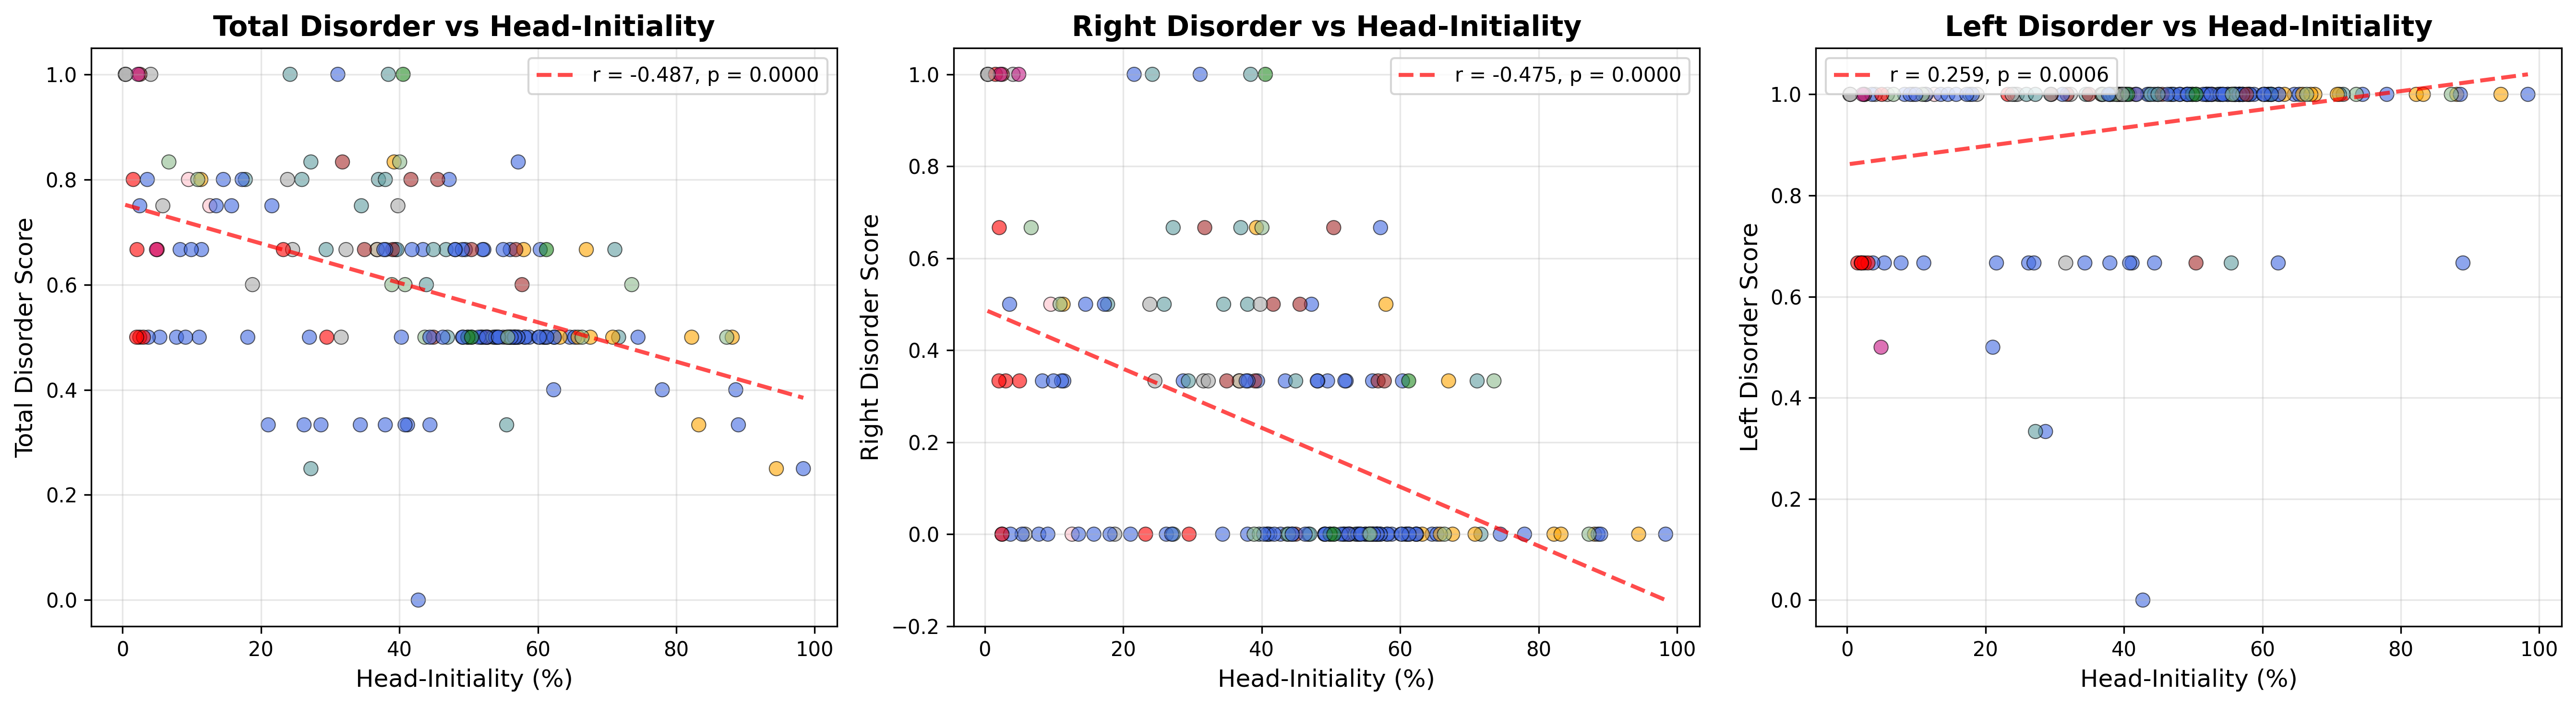

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

if merged_df is not None:
    # Set up the plot style
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.size'] = 10
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Filter out languages with missing data
    plot_df = merged_df.dropna(subset=['head_initiality', 'disorder_score', 'right_disorder_score', 'left_disorder_score'])
    
    # Get color mapping from metadata
    group_to_color = metadata.get('appearance_dict', {})
    colors = [group_to_color.get(g, '#888888') for g in plot_df['group']]
    
    print(f"Plotting {len(plot_df)} languages with complete data")
    
    # Plot 1: Total Disorder vs Head-Initiality
    ax = axes[0]
    ax.scatter(plot_df['head_initiality'], plot_df['disorder_score'], 
               c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Add regression line (convert to numpy arrays to ensure proper dtype)
    x_data = plot_df['head_initiality'].values.astype(float)
    y_data = plot_df['disorder_score'].values.astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    x_line = np.array([plot_df['head_initiality'].min(), plot_df['head_initiality'].max()])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
            label=f'r = {r_value:.3f}, p = {p_value:.4f}')
    
    ax.set_xlabel('Head-Initiality (%)', fontsize=12)
    ax.set_ylabel('Total Disorder Score', fontsize=12)
    ax.set_title('Total Disorder vs Head-Initiality', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    # Plot 2: Right Disorder vs Head-Initiality
    ax = axes[1]
    ax.scatter(plot_df['head_initiality'], plot_df['right_disorder_score'],
               c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    x_data = plot_df['head_initiality'].values.astype(float)
    y_data = plot_df['right_disorder_score'].values.astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    x_line = np.array([plot_df['head_initiality'].min(), plot_df['head_initiality'].max()])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
            label=f'r = {r_value:.3f}, p = {p_value:.4f}')
    
    ax.set_xlabel('Head-Initiality (%)', fontsize=12)
    ax.set_ylabel('Right Disorder Score', fontsize=12)
    ax.set_title('Right Disorder vs Head-Initiality', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    # Plot 3: Left Disorder vs Head-Initiality
    ax = axes[2]
    ax.scatter(plot_df['head_initiality'], plot_df['left_disorder_score'],
               c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    x_data = plot_df['head_initiality'].values.astype(float)
    y_data = plot_df['left_disorder_score'].values.astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    x_line = np.array([plot_df['head_initiality'].min(), plot_df['head_initiality'].max()])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
            label=f'r = {r_value:.3f}, p = {p_value:.4f}')
    
    ax.set_xlabel('Head-Initiality (%)', fontsize=12)
    ax.set_ylabel('Left Disorder Score', fontsize=12)
    ax.set_title('Left Disorder vs Head-Initiality', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(OUTPUT_DIR, 'disorder_vs_head_initiality.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure to {fig_path}")
    
    plt.show()
else:
    print("Skipping scatter plots - merged data not available")

## 8. Scatter Plots: Disorder vs VO Score

Visualize the relationship between disorder and VO score (if available).

## 7b. Per-Configuration Disorder Analysis

Analyze disorder for individual configurations (e.g., V X, V X X, V X X X) to see if specific patterns emerge.

\nSaved per-configuration plot to data/disorder_per_config_vs_head_initiality.png


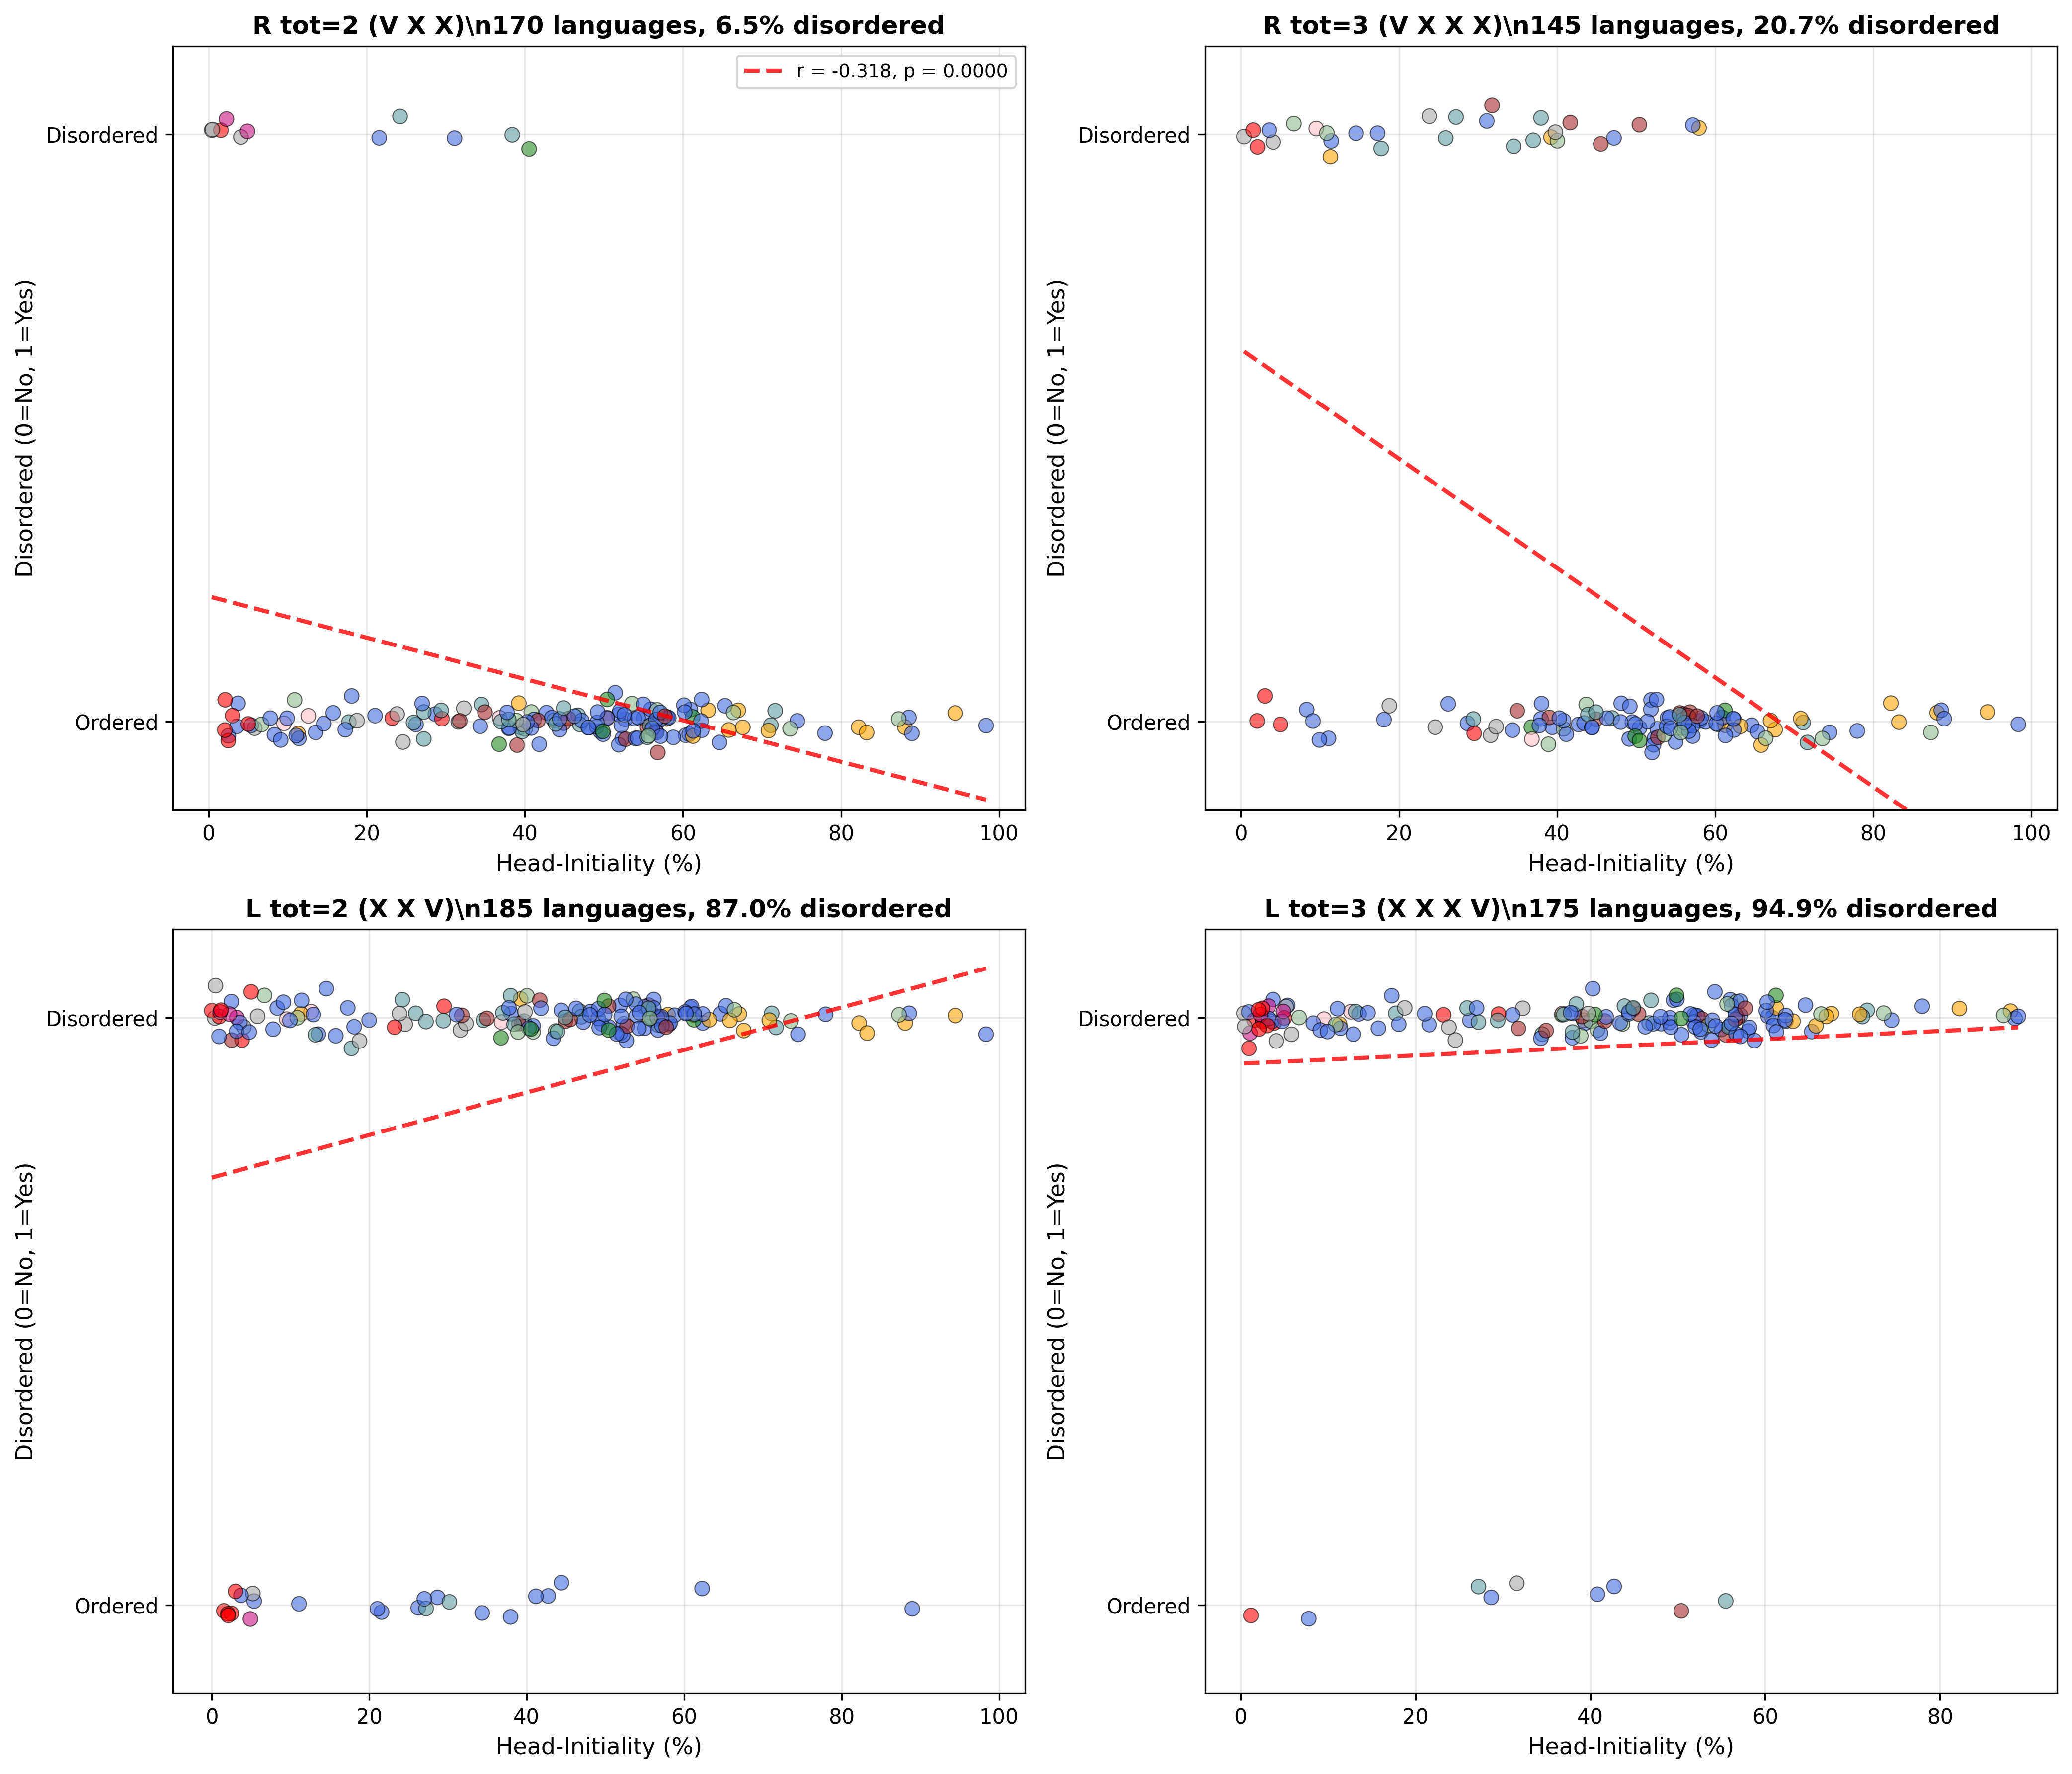

In [15]:
if merged_df is not None:
    # Per-configuration scatter plots vs head-initiality
    # Focus on specific configurations with most data
    
    configs_to_plot = [
        ('right_tot_2_disordered', 'R tot=2 (V X X)', 170),
        ('right_tot_3_disordered', 'R tot=3 (V X X X)', 145),
        ('left_tot_2_disordered', 'L tot=2 (X X V)', 185),
        ('left_tot_3_disordered', 'L tot=3 (X X X V)', 175),
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    # Color mapping
    plot_df_config = merged_df.dropna(subset=['head_initiality'])
    colors = [group_to_color.get(g, '#808080') for g in plot_df_config['group']]
    
    for idx, (config_col, config_label, n_langs) in enumerate(configs_to_plot):
        ax = axes[idx]
        
        # Get data for this configuration
        config_df = plot_df_config[plot_df_config[config_col].notna()].copy()
        config_colors = [group_to_color.get(g, '#808080') for g in config_df['group']]
        
        # Convert boolean to float (0.0 or 1.0)
        config_df['disorder_binary'] = config_df[config_col].astype(float)
        
        # Add jitter to separate overlapping points
        np.random.seed(42)
        y_jitter = config_df['disorder_binary'].values + np.random.normal(0, 0.02, len(config_df))
        
        ax.scatter(config_df['head_initiality'], y_jitter,
                   c=config_colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Compute correlation with binary disorder
        x_data = config_df['head_initiality'].values.astype(float)
        y_data = config_df['disorder_binary'].values.astype(float)
        
        if len(x_data) > 2:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
            
            # Plot regression line
            x_line = np.array([config_df['head_initiality'].min(), config_df['head_initiality'].max()])
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.8,
                    label=f'r = {r_value:.3f}, p = {p_value:.4f}')
        
        # Count disorder percentage
        disorder_pct = (config_df['disorder_binary'].sum() / len(config_df)) * 100
        
        ax.set_xlabel('Head-Initiality (%)', fontsize=11)
        ax.set_ylabel('Disordered (0=No, 1=Yes)', fontsize=11)
        ax.set_title(f'{config_label}\\n{len(config_df)} languages, {disorder_pct:.1f}% disordered', 
                     fontsize=12, fontweight='bold')
        ax.set_ylim(-0.15, 1.15)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Ordered', 'Disordered'])
        if idx == 0:
            ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(OUTPUT_DIR, 'disorder_per_config_vs_head_initiality.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\\nSaved per-configuration plot to {fig_path}")
    
    plt.show()
else:
    print("Skipping per-configuration plots - merged data not available")

In [16]:
# Additional analysis: Show disorder percentage by configuration
if merged_df is not None:
    print("\n" + "="*60)
    print("DISORDER PERCENTAGE BY CONFIGURATION")
    print("="*60)
    
    all_configs = [
        ('right_tot_2_disordered', 'R tot=2 (V X X)'),
        ('right_tot_3_disordered', 'R tot=3 (V X X X)'),
        ('right_tot_4_disordered', 'R tot=4 (V X X X X)'),
        ('left_tot_2_disordered', 'L tot=2 (X X V)'),
        ('left_tot_3_disordered', 'L tot=3 (X X X V)'),
        ('left_tot_4_disordered', 'L tot=4 (X X X X V)'),
    ]
    
    for config_col, config_label in all_configs:
        if config_col in merged_df.columns:
            config_data = merged_df[config_col].dropna()
            n_total = len(config_data)
            n_disordered = config_data.astype(int).sum()
            pct = (n_disordered / n_total * 100) if n_total > 0 else 0
            print(f"{config_label:25} {n_disordered:3d}/{n_total:3d} languages ({pct:5.1f}%) disordered")
    
    print("="*60)


DISORDER PERCENTAGE BY CONFIGURATION
R tot=2 (V X X)            11/170 languages (  6.5%) disordered
R tot=3 (V X X X)          30/145 languages ( 20.7%) disordered
R tot=4 (V X X X X)        44/121 languages ( 36.4%) disordered
L tot=2 (X X V)           161/185 languages ( 87.0%) disordered
L tot=3 (X X X V)         166/175 languages ( 94.9%) disordered
L tot=4 (X X X X V)       158/159 languages ( 99.4%) disordered


## 7c. Per-Sentence Disorder Analysis

Load sentence-level disorder percentages computed in notebook 02.

**Note**: You must run notebook 02 with `compute_sentence_disorder=True` to generate this data.

In [ ]:
# Load pre-computed sentence disorder percentages from notebook 02
sentence_disorder_path = os.path.join(DATA_DIR, 'sentence_disorder_percentages.csv')

if os.path.exists(sentence_disorder_path):
    sentence_disorder_df = pd.read_csv(sentence_disorder_path)
    print(f"Loaded sentence-level disorder for {len(sentence_disorder_df)} languages")
    print(f"\nColumns: {list(sentence_disorder_df.columns)}")
    print("\nSample data:")
    print(sentence_disorder_df[['language_code', 'language_name', 'right_tot_2_pct', 'left_tot_2_pct']].head())
else:
    print(f"Sentence disorder data not found at {sentence_disorder_path}")
    print("\nTo generate this data:")
    print("1. Open notebook 02_dependency_analysis.ipynb")
    print("2. Set compute_sentence_disorder=True in section 2b")
    print("3. Run the notebook (will take 10-30 minutes)")
    sentence_disorder_df = None

Found short CoNLL directory: 2.17_short
Found 186 languages with CoNLL files
Example: ['abq', 'ab', 'af', 'akk', 'aqz']


In [ ]:
# Compare sentence-level vs average-level disorder

if sentence_disorder_df is not None and merged_df is not None:
    print("="*70)
    print("COMPARISON: Sentence-Level vs Average-Level Disorder")
    print("="*70)
    print()
    print("Sentence-level: % of sentences with disordered constituents")
    print("Average-level: binary (is the average disordered?)")
    print()
    
    # Merge the two approaches
    comparison_df = merged_df[['language_code', 'language_name', 'group', 
                                'right_tot_2_disordered', 'right_tot_3_disordered',
                                'left_tot_2_disordered', 'left_tot_3_disordered']].merge(
        sentence_disorder_df[['language_code', 'right_tot_2_pct', 'right_tot_3_pct', 
                               'left_tot_2_pct', 'left_tot_3_pct']],
        on='language_code',
        how='inner'
    )
    
    # Convert binary columns to percentages
    comparison_df['right_tot_2_binary_pct'] = comparison_df['right_tot_2_disordered'].astype(float) * 100
    comparison_df['left_tot_2_binary_pct'] = comparison_df['left_tot_2_disordered'].astype(float) * 100
    
    print(f"Comparison for {len(comparison_df)} languages:")
    print()
    print("Right tot=2 (V X X):")
    print(f"  Sentence-level avg: {comparison_df['right_tot_2_pct'].mean():.1f}% of sentences disordered")
    print(f"  Average-level: {comparison_df['right_tot_2_binary_pct'].mean():.1f}% of languages have disordered averages")
    print()
    print("Left tot=2 (X X V):")
    print(f"  Sentence-level avg: {comparison_df['left_tot_2_pct'].mean():.1f}% of sentences disordered")
    print(f"  Average-level: {comparison_df['left_tot_2_binary_pct'].mean():.1f}% of languages have disordered averages")
    print()
    
    # Show some example languages with large differences
    comparison_df['right_tot_2_diff'] = abs(comparison_df['right_tot_2_pct'] - comparison_df['right_tot_2_binary_pct'])
    comparison_df['left_tot_2_diff'] = abs(comparison_df['left_tot_2_pct'] - comparison_df['left_tot_2_binary_pct'])
    
    print("\nTop 10 languages with largest difference (right tot=2):")
    print(comparison_df[['language_name', 'right_tot_2_pct', 'right_tot_2_binary_pct', 'right_tot_2_diff']]\
          .sort_values('right_tot_2_diff', ascending=False).head(10).to_string(index=False))
    
    print("\n\nTop 10 languages with largest difference (left tot=2):")
    print(comparison_df[['language_name', 'left_tot_2_pct', 'left_tot_2_binary_pct', 'left_tot_2_diff']]\
          .sort_values('left_tot_2_diff', ascending=False).head(10).to_string(index=False))
    
    print("\n" + "="*70)
else:
    if sentence_disorder_df is None:
        print("Skipping comparison - sentence-level disorder data not available")
        print("Run notebook 02 with compute_sentence_disorder=True to generate this data")
    else:
        print("Skipping comparison - merged data not available")

In [22]:
# Try to load VO score data if available
vo_score_paths = [
    'data/vo_hi_df.csv',
    'vo_hi_df.csv',
    'data/vo_scores.csv',
    'vo_scores.csv'
]

vo_df = None
for vo_path in vo_score_paths:
    if os.path.exists(vo_path):
        vo_df = pd.read_csv(vo_path)
        print(f"Loaded VO score data from {vo_path}")
        print(f"Columns: {vo_df.columns.tolist()}")
        print(vo_df.head())
        break

if vo_df is None:
    print("VO score data not found. Checked paths:")
    for p in vo_score_paths:
        print(f"  - {p}")
    print("\nNote: VO scores need to be computed from object dependency data.")
    print("This is typically done by computing head-initiality specifically for obj/OBJ relations.")

VO score data not found. Checked paths:
  - data/vo_hi_df.csv
  - vo_hi_df.csv
  - data/vo_scores.csv
  - vo_scores.csv

Note: VO scores need to be computed from object dependency data.
This is typically done by computing head-initiality specifically for obj/OBJ relations.


In [23]:
if vo_df is not None and merged_df is not None:
    # Determine VO score column name
    vo_col = None
    for col in ['vo_score', 'VO_score', 'vo_initiality', 'vo_percent']:
        if col in vo_df.columns:
            vo_col = col
            break
    
    if vo_col is None:
        print("Could not identify VO score column in the data")
        print(f"Available columns: {vo_df.columns.tolist()}")
    else:
        # Merge VO scores with disorder data
        merged_vo_df = merged_df.merge(
            vo_df[['language_code', vo_col]],
            on='language_code',
            how='left'
        )
        
        # Filter out missing data
        plot_vo_df = merged_vo_df.dropna(subset=[vo_col, 'disorder_score', 'right_disorder_score', 'left_disorder_score'])
        
        print(f"\nMerged VO scores for {len(plot_vo_df)} languages")
        print(f"\nCorrelations with VO score ({vo_col}):")
        if len(plot_vo_df) > 2:
            print(f"  Total disorder: r = {plot_vo_df[['disorder_score', vo_col]].corr().iloc[0,1]:.3f}")
            print(f"  Right disorder: r = {plot_vo_df[['right_disorder_score', vo_col]].corr().iloc[0,1]:.3f}")
            print(f"  Left disorder:  r = {plot_vo_df[['left_disorder_score', vo_col]].corr().iloc[0,1]:.3f}")
        
        # Create scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        colors = [group_to_color.get(g, '#888888') for g in plot_vo_df['group']]
        
        # Plot 1: Total Disorder vs VO Score
        ax = axes[0]
        ax.scatter(plot_vo_df[vo_col], plot_vo_df['disorder_score'],
                   c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        x_data = plot_vo_df[vo_col].values.astype(float)
        y_data = plot_vo_df['disorder_score'].values.astype(float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
        x_line = np.array([plot_vo_df[vo_col].min(), plot_vo_df[vo_col].max()])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
                label=f'r = {r_value:.3f}, p = {p_value:.4f}')
        
        ax.set_xlabel('VO Score (%)', fontsize=12)
        ax.set_ylabel('Total Disorder Score', fontsize=12)
        ax.set_title('Total Disorder vs VO Score', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        
        # Plot 2: Right Disorder vs VO Score
        ax = axes[1]
        ax.scatter(plot_vo_df[vo_col], plot_vo_df['right_disorder_score'],
                   c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        x_data = plot_vo_df[vo_col].values.astype(float)
        y_data = plot_vo_df['right_disorder_score'].values.astype(float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
        x_line = np.array([plot_vo_df[vo_col].min(), plot_vo_df[vo_col].max()])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
                label=f'r = {r_value:.3f}, p = {p_value:.4f}')
        
        ax.set_xlabel('VO Score (%)', fontsize=12)
        ax.set_ylabel('Right Disorder Score', fontsize=12)
        ax.set_title('Right Disorder vs VO Score', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        
        # Plot 3: Left Disorder vs VO Score
        ax = axes[2]
        ax.scatter(plot_vo_df[vo_col], plot_vo_df['left_disorder_score'],
                   c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        x_data = plot_vo_df[vo_col].values.astype(float)
        y_data = plot_vo_df['left_disorder_score'].values.astype(float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
        x_line = np.array([plot_vo_df[vo_col].min(), plot_vo_df[vo_col].max()])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', alpha=0.7, linewidth=2,
                label=f'r = {r_value:.3f}, p = {p_value:.4f}')
        
        ax.set_xlabel('VO Score (%)', fontsize=12)
        ax.set_ylabel('Left Disorder Score', fontsize=12)
        ax.set_title('Left Disorder vs VO Score', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        fig_path = os.path.join(OUTPUT_DIR, 'disorder_vs_vo_score.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"\nSaved figure to {fig_path}")
        
        plt.show()
        
        # Save merged data
        merged_vo_path = os.path.join(OUTPUT_DIR, 'disorder_with_vo_score.csv')
        merged_vo_df.to_csv(merged_vo_path, index=False)
        print(f"Saved merged data to {merged_vo_path}")
else:
    if vo_df is None:
        print("Skipping VO score plots - VO score data not available")
    else:
        print("Skipping VO score plots - merged disorder data not available")

Skipping VO score plots - VO score data not available


In [24]:
# 

In [25]:
# Print the complex table with growth factors
import verb_centered_analysis
from importlib import reload
reload(verb_centered_analysis)

if 'position_averages' in locals():
    table_with_factors = verb_centered_analysis.format_verb_centered_table(position_averages, show_horizontal_factors=True, arrow_direction='diverging')
    print(table_with_factors)
else:
    print("position_averages variable not found. Please run previous cells.")

VERB-CENTERED CONSTITUENT SIZE TABLE
WITH GROWTH FACTORS

                                                                            V                                                                       
R tot=4:                                                                      V   1.878  ×1.32 →      2.475  ×1.35 →      3.350  ×2.00 →      6.684
R tot=3:                                                                      V   1.757  ×1.56 →      2.744  ×2.07 →      5.689
R tot=2:                                                                      V   2.000  ×2.38 →      4.753
R tot=1:                                                                      V   4.326
------------------------------------------------------------------------------------------------------------------------
L tot=1:                                                                2.251 V
L tot=2:                                            1.853  ×0.76 ←      2.429 V
L tot=3:                        1.749  ×

In [26]:
# Print the even more complex table with DIAGONAL growth factors
import verb_centered_analysis
from importlib import reload
reload(verb_centered_analysis)

if 'position_averages' in locals():
    table_diag = verb_centered_analysis.format_verb_centered_table(position_averages, show_horizontal_factors=True, show_diagonal_factors=True, arrow_direction='rightwards')
    print(table_diag)
else:
    print("position_averages variable not found. Please run previous cells.")

VERB-CENTERED CONSTITUENT SIZE TABLE
WITH GROWTH FACTORS

                                                                            V                                                                       
R tot=4:                                                                      V   1.878  ×1.32 →      2.475  ×1.35 →      3.350  ×2.00 →      6.684
                                                                                         ×1.41 ↗             ×1.22 ↗             ×1.17 ↗           
R tot=3:                                                                      V   1.757  ×1.56 →      2.744  ×2.07 →      5.689
                                                                                         ×1.37 ↗             ×1.20 ↗           
R tot=2:                                                                      V   2.000  ×2.38 →      4.753
                                                                                         ×1.10 ↗           
R tot=1:                 

In [27]:
# Print the even more complex table with DIAGONAL growth factors
import verb_centered_analysis
from importlib import reload
reload(verb_centered_analysis)

if 'position_averages' in locals():
    table_diag = verb_centered_analysis.format_verb_centered_table(position_averages, show_horizontal_factors=True, show_diagonal_factors=True, arrow_direction='rightwards')
    print(table_diag)
else:
    print("position_averages variable not found. Please run previous cells.")

VERB-CENTERED CONSTITUENT SIZE TABLE
WITH GROWTH FACTORS

                                                                            V                                                                       
R tot=4:                                                                      V   1.878  ×1.32 →      2.475  ×1.35 →      3.350  ×2.00 →      6.684
                                                                                         ×1.41 ↗             ×1.22 ↗             ×1.17 ↗           
R tot=3:                                                                      V   1.757  ×1.56 →      2.744  ×2.07 →      5.689
                                                                                         ×1.37 ↗             ×1.20 ↗           
R tot=2:                                                                      V   2.000  ×2.38 →      4.753
                                                                                         ×1.10 ↗           
R tot=1:                 